<a href="https://colab.research.google.com/github/flying-bear/modeling_schizo/blob/master/Reembed_and_apply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get raw frequency counts on RuWac + Sample

### Load the lemmatized ELMo model from [rusvectores](https://rusvectores.org/ru/models/)

In [0]:
!wget https://github.com/flying-bear/modeling_schizo/blob/master/word_freq.zip?raw=true -O word_freq.zip

--2020-05-06 16:41:23--  https://github.com/flying-bear/modeling_schizo/blob/master/word_freq.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/flying-bear/modeling_schizo/raw/master/word_freq.zip [following]
--2020-05-06 16:41:24--  https://github.com/flying-bear/modeling_schizo/raw/master/word_freq.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/flying-bear/modeling_schizo/master/word_freq.zip [following]
--2020-05-06 16:41:24--  https://raw.githubusercontent.com/flying-bear/modeling_schizo/master/word_freq.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HT

In [0]:
!unzip word_freq.zip

Archive:  word_freq.zip
replace word_freq.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### Install stuff

In [146]:
!pip install allennlp

In [0]:
!pip install pymystem3==0.1.10

  Found existing installation: pymystem3 0.2.0
    Uninstalling pymystem3-0.2.0:
      Successfully uninstalled pymystem3-0.2.0


In [0]:
!pip install pymorphy2

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 6.7MB/s 


In [0]:
!pip install deeppavlov

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 10.4MB 13.6MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 1.5MB 44.6MB/s 
     |████████████████████████████████| 7.3MB 43.4MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 2.1MB 43.4MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 8.0MB 45.9MB/s 
     |████████████████████████████████| 665kB 42.2MB/s 
     |████████████████████████████████| 6.7MB 47.0MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 2.7MB 44.9MB/s 
     |██

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 2.6MB/s 
     |████████████████████████████████| 890kB 8.1MB/s 
     |████████████████████████████████| 3.7MB 15.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=d445cf807a2177872f5bc542b7bdcfde6b1a6e7a9ca49c41fac5d9979841fe2c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Imports and initializations

In [0]:
import numpy as np
import os
import pandas as pd
import pymorphy2
import pickle
import re

from allennlp.commands.elmo import ElmoEmbedder
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from gensim.models import KeyedVectors
from collections import Counter
from pymystem3 import Mystem
from sklearn.decomposition import TruncatedSVD
from tqdm.notebook import tqdm

In [0]:
mystem_analyzer = Mystem()
morph=pymorphy2.MorphAnalyzer()
tqdm.pandas()

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]

### Preprocessing

In [0]:
def tokenize(text): 
  """
  cleans a text of punctuation and case
  
  :param text: str to be cleaned
  :return: list of str (words) in lowercase and stripped of punctuation
  """
  low = text.lower()
  stripped = re.sub('«|»|„|“|!|\.|,|#|$|%|\\|\'|\(|\)|\+|\*|/|\:|;|<|>|=|\?|\[|\]|@|^|_|`|{|}|~', '', low)
  words = stripped.split()
  return words

def lemmatize(words, method='mystem'):
  """
  lemmatizes string using MyStem or PyMorphy
  
  :param words: list of str, words to be lemmatized
  :param method: str, 'mystem' or 'pymorphy', method to be used, optional, default='mystem'
  :return: list of str, lemmatized words (strings)
  """
  if method == 'mystem':
    return [mystem_analyzer.lemmatize(word)[0] for word in words]
  else:
    return [morph.parse(word)[0].normal_form for word in words]

In [0]:
ex_text = 'Я не думаю, что это заработает...'
print(lemmatize(tokenize(ex_text)))
print(lemmatize(tokenize(ex_text), method='pymorphy'))

['я', 'не', 'думать', 'что', 'это', 'зарабатывать']
['я', 'не', 'думать', 'что', 'это', 'заработать']


# Load & preprocess dataset

In [0]:
data = pd.read_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/stories.csv', index_col=0)
data.tail(2)

,child,gift,suit,chair
ID,,,,
S20,//на этой на коляс= · о(0.3) · //на этой ...,//вот ну мне моя девушка испекла торт · (0.8...,//ну значит был человек · /который очень сте...,//вот ну в начале делаются ну по бокам ножки ...
S21,//ну началось с того · /что малыш с мамой с ...,NaN,//ну здесь встретились два мужчины · //один ...,NaN


In [0]:
def preprocess_raw_elan(text):
  if pd.isnull(text):
    return pd.Series((np.nan, np.nan, np.nan))
  if not text.startswith('//'):
    text = '//' + text.split('//', 1)[1]
  utt_num = len(text.split('//'))
  text = text.replace('//', '/')
  text = text.replace('ё', 'е')
  text = text.replace('  ·  ', ' ')
  text = re.sub('[а-я]*\([0-9]+(.[0-9])?\)', '', text)
  text = re.sub('[а-я]+=|\*[а-я]+', '',  text)
  text = re.sub('\(exp:.+?\)', ' ', text)
  text = re.sub('\s+', ' ', text)
  edus = text.split('/')
  edu_num = len(edus)
  return pd.Series(([edu.split() for edu in edus if edu], utt_num, edu_num))

In [0]:
tests = ['child', 'chair', 'gift', 'suit']
for col in tests:
  to_add = data[col].progress_apply(preprocess_raw_elan)
  to_add.columns = [f'{col}_edus', f'{col}_utt_num', f'{col}_edu_num']
  data = pd.concat([data, to_add], axis=1)

In [0]:
data.tail()

,child,gift,suit,chair,child_edus,child_utt_num,child_edu_num,chair_edus,chair_utt_num,chair_edu_num,gift_edus,gift_utt_num,gift_edu_num,suit_edus,suit_utt_num,suit_edu_num
ID,,,,,,,,,,,,,,,,
S17,//ну на первой · (0.4) · э(0.3) · строчк...,//ну · (10.9) · ну наверное это серьги · ...,//а здесь вот · (0.7) · один грозный мужчи...,э(0.6) · (3.2) · //нужно взять стул · (0...,"[[ну, на, первой, строчке, происходит, то], [ч...",12,18,"[[нужно, взять, стул, его, часть, и, табуретку...",12.0,14.0,"[[ну, ну, наверное, это, серьги], [которые, по...",4.0,6.0,"[[а, здесь, вот, один, грозный, мужчина, и, др...",11.0,13.0
S18,э(0.5) · //на этой картинке · (0.7) · э(...,//ну · (0.6) · я могу рассказать о подарке...,//мужчина видит прохожего мужчину · (2.8) ·...,//так на первой картинке изображено · /как с...,"[[на, этой, картинке, бабушка, или, мама, гово...",17,20,"[[так, на, первой, картинке, изображено], [как...",18.0,30.0,"[[ну, я, могу, рассказать, о, подарке, в, каче...",66.0,87.0,"[[мужчина, видит, прохожего, мужчину], [мужчин...",17.0,17.0
S19,эх(0.5) · //сейчас посмотрим · (2.0) · м...,//привет меня зовут · //меня звух так барвсе...,//идет · э(0.2) · здоровый мужик · э= ·...,//сначала *сначала что там идёт не понятно воо...,"[[сейчас, посмотрим], [в, общем, папа, пошел, ...",19,20,"[[сначала, что, там, идет, не, понятно, вообще...",24.0,33.0,"[[привет, меня, зовут], [меня, звух, так, барв...",12.0,13.0,"[[идет, здоровый, мужик, качок], [хочет, заста...",19.0,19.0
S20,//на этой на коляс= · о(0.3) · //на этой ...,//вот ну мне моя девушка испекла торт · (0.8...,//ну значит был человек · /который очень сте...,//вот ну в начале делаются ну по бокам ножки ...,"[[на, этой, на], [на, этой, странице, видно], ...",14,19,"[[вот, ну, в, начале, делаются, ну, по, бокам,...",11.0,13.0,"[[вот, ну, мне, моя, девушка, испекла, торт, о...",4.0,4.0,"[[ну, значит, был, человек], [который, очень, ...",8.0,14.0
S21,//ну началось с того · /что малыш с мамой с ...,NaN,//ну здесь встретились два мужчины · //один ...,NaN,"[[ну, началось, с, того], [что, малыш, с, мамо...",31,41,NaN,NaN,NaN,NaN,NaN,NaN,"[[ну, здесь, встретились, два, мужчины], [один...",16.0,20.0


In [0]:
for col in tests:
  data[f'{col}_lemmas'] = data[f'{col}_edus'][~pd.isnull(data[f'{col}_edus'])].progress_apply(lambda edus: [lemmatize(edu, method='pymorphy') for edu in edus])

In [0]:
data[['child_utt_num', 'child_edu_num', 'chair_utt_num', 'chair_edu_num', 'gift_utt_num', 'gift_edu_num', 'suit_utt_num', 'suit_edu_num']].to_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/EDU_NUM.csv')

In [0]:
for col in tests:
  data[f'{col}_mean_edu_len'] = data[f'{col}_edus'][~pd.isnull(data[f'{col}_edus'])].apply(lambda edus: np.mean([len(edu) for edu in edus]))
  data[f'{col}_min_edu_len'] = data[f'{col}_edus'][~pd.isnull(data[f'{col}_edus'])].apply(lambda edus: min([len(edu) for edu in edus]))
  data[f'{col}_max_edu_len'] = data[f'{col}_edus'][~pd.isnull(data[f'{col}_edus'])].apply(lambda edus: max([len(edu) for edu in edus]))
  data[f'{col}_word_count'] = data[f'{col}_edus'][~pd.isnull(data[f'{col}_edus'])].apply(lambda edus: np.sum([len(edu) for edu in edus]))

In [0]:
names = 'child_mean_edu_len	child_min_edu_len	child_max_edu_len	child_word_count	chair_mean_edu_len	chair_min_edu_len	chair_max_edu_len	chair_word_count	gift_mean_edu_len	gift_min_edu_len	gift_max_edu_len	gift_word_count	suit_mean_edu_len	suit_min_edu_len	suit_max_edu_len	suit_word_count'.split()
data[names].to_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/NUM.csv')

# Sentence embeddings from vector embeddings
[A SIMPLE BUT TOUGH-TO-BEAT BASELINE FOR SENTENCE EMBEDDINGS](https://openreview.net/pdf?id=SyK00v5xx)

[their repo](https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py)

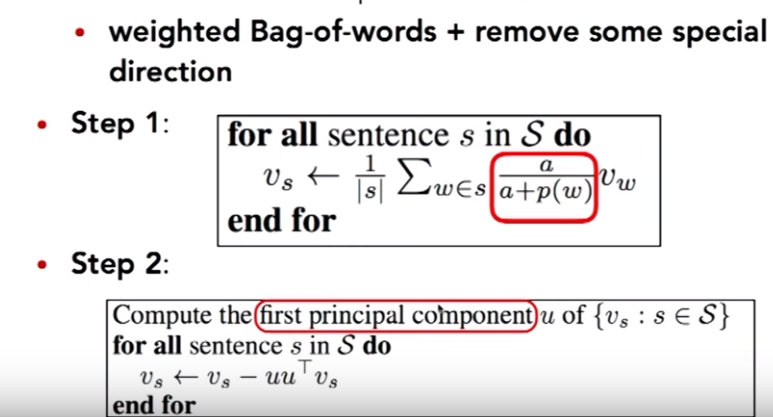

a = $10^{-3}$ or $10^{-4}$

p(w) - raw count in a large corpus

### Frequencies

In [0]:
with open('word_freq.pickle', 'rb') as f:
  word_freq = pickle.load(f)

In [0]:
word_freq['я']

13405856

In [0]:
corpus_size = sum(word_freq.values()) 
corpus_size

1296570215

In [0]:
def ipm(counter, word, corpus_size):
  return counter[word]/ (corpus_size/1000000)

In [0]:
ipm(word_freq, 'я', corpus_size)

10339.47552157829

In [0]:
freqs = {word:ipm(word_freq, word, corpus_size) for word in word_freq}

In [0]:
freqs['я']

10339.47552157829

In [0]:
freqs = Counter(freqs)

In [0]:
def smooth(freq, factor=10e-3):
  return factor / (factor + freq)

In [0]:
smooth(freqs['я'])

9.671661108408353e-07

In [0]:
smooth(word_freq['я'])

7.459426680803205e-10

## get w2v embeddings

In [0]:
!wget http://vectors.nlpl.eu/repository/20/187.zip

--2020-05-06 16:44:22--  http://vectors.nlpl.eu/repository/20/187.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2692389554 (2.5G) [application/zip]
Saving to: ‘187.zip’

187.zip             100%[===================>]   2.51G  9.65MB/s    in 4m 42s  

2020-05-06 16:49:06 (9.10 MB/s) - ‘187.zip’ saved [2692389554/2692389554]



In [0]:
!unzip 187.zip -d /187

Archive:  187.zip
  inflating: /187/meta.json          
  inflating: /187/model.model        
  inflating: /187/model.model.vectors_ngrams.npy  
  inflating: /187/model.model.vectors.npy  
  inflating: /187/model.model.vectors_vocab.npy  
  inflating: /187/README             


In [0]:
wv = KeyedVectors.load('/187/model.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
wv['вошь'][-10:]

array([-0.78309405,  4.2954803 ,  1.9717869 ,  6.6264105 , -3.0730708 ,
        0.61173576,  2.7075362 ,  3.0496023 , -0.03352385,  3.0363846 ],
      dtype=float32)

In [0]:
oov_list = []
oov_bad = []
total = 0
def get_edus_vectors(edus, model, idfs, oov_list, oov_bad):
    if type(edus) != list:
      return np.nan
    edus_vectors = []
    for edu in edus:
        edu_vect_array = []
        edu_idf_array = []
        for word in edu:
            global total
            total += 1
            try:
                vect = model[word]
                idf = smooth(idfs[word])
            except KeyError:
                oov_list.append(word)
                continue
            except AttributeError as e:
              oov_bad.append(word)
              continue
            if idf:
                edu_vect_array.append(vect)
                edu_idf_array.append(idf)
            else:
                continue
        if edu_idf_array:
            edu_vector = np.average(edu_vect_array, weights=edu_idf_array, axis=0)
            edus_vectors.append(edu_vector)
        else:
            continue
    return edus_vectors

In [0]:
len(get_edus_vectors(data['chair_lemmas']['S01'], wv, freqs, oov_list, oov_bad))

24

In [0]:
set(oov_bad)

{'дваск', 'и', 'к', 'кажется', 'я'}

In [0]:
def vectorize_column(df, lemmas_col_name, wv, oov_list, oov_bad, idfs=None):
  """
  vectorizes a pd.DataFrame column with lemmas

  :param df: pd.Dataframe
  :param lemmas_col_name: str, column name in df with lists of str (lemmas)
  :param wv: gensim w2v model
  :param idfs: collections.Counter for weighting
  :param oov_list: list to add oov to
  :param oov_bad: list to add attribute oov to
  :return: np.ndarray of shape (len(df), wv.vector_size)
  """
  vecs = df[lemmas_col_name].progress_apply(lambda text: get_edus_vectors(text, model=wv, idfs=idfs, oov_list=oov_list, oov_bad=oov_bad))
  return vecs

In [0]:
vectorize_column(data, 'chair_lemmas', wv, oov_list, oov_bad, freqs)

ID
H01    [[0.692720495589204, 1.014837800579202, 0.2793...
H02    [[-1.0763762144460236, 0.6025274997343076, 0.3...
H03    [[-1.391371010139199, -0.316403146478882, 0.64...
H04    [[-1.4332971572875977, -1.0885951519012451, 1....
H05    [[-0.047409266466349825, 0.060287894648481256,...
H06    [[-0.6306749550681139, 0.2126163464383049, 1.0...
H07    [[-1.1267205449268307, 0.6173590823542889, 0.3...
H08    [[-1.1264517975335153, 0.9987385780944938, 0.6...
H09    [[-1.3740126905058532, 0.43091119703181757, 0....
H10    [[-4.432866339247423, 1.0317723312504297, -3.2...
H11    [[-1.1205984019897104, 0.5930615661233984, 0.3...
H12    [[0.9147059693261343, -0.6132536425925496, 1.6...
H13    [[2.412039966235427, -1.8823893398809999, -1.1...
H14    [[-0.9064420394432036, 0.02139205814295135, 0....
H15    [[1.571717037395782, 0.40909856963595204, 0.55...
H16    [[-0.19055534920428746, 0.37428427361109806, 0...
H17    [[-1.457224387871151, 0.1360404340548442, 0.53...
H18    [[-1.3815539986596364

In [0]:
for col in ['child_lemmas', 'chair_lemmas', 'gift_lemmas', 'suit_lemmas']:
  data[f'{col}_w2v'] = vectorize_column(data, col, wv, oov_list, oov_bad, freqs)

In [0]:
len(oov_bad)/total

0.13727707064444364

## PCA for sentence embeddings


In [0]:
def compute_pc(X, npc=1):
    """
    Computes the principal components. DOES NOT MAKE THE DATA ZERO MEAN!

    :param X: np.ndarray of shape (sent_len, emb_dim), X[i,:] is a data point
    :param npc: int > 0, number of principal components to compute, optional, default 1
    :return: np.ndarray of shape (npc, emb_dim), component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1, pc=None):
    """
    Removes the projection on the principal components

    :param X: np.ndarray of shape (sent_len, emb_dim), X[i,:] is a data point
    :param npc: int > 0, number of principal components to remove, optional, default 1
    :param pc: np.ndarray of shape (1, emb_dim), optional, default None
    :return: np.ndarray of shape (sent_len, emb_dim), X[i,:], XX[i, :] is the data point after removing its projection
    """
    if pc is None:
      pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [0]:
x = np.random.rand(10,20)
print(f'shape of compute_pc:\nx: {x.shape}\ncompute_pc(x, 2): {compute_pc(x, 2).shape}')
print()
print(f'shape does not chage after removal:\nbefore: {x.shape}\nafter: {remove_pc(x, 2).shape}')

shape of compute_pc:
x: (10, 20)
compute_pc(x, 2): (2, 20)

shape does not chage after removal:
before: (10, 20)
after: (10, 20)


In [0]:
all_sent_emb = []
for w2v_col in [f'{col}_lemmas_w2v' for col in tests]:
  all_sent_emb  += flatten(data[w2v_col].dropna().values)

In [0]:
pc_to_remove = compute_pc(np.array(all_sent_emb))

In [0]:
remove_pc(data['child_lemmas_w2v']['H01'][0], pc=pc_to_remove).shape

(1, 300)

In [0]:
def apply_remove_pc(edu_w2v_list, pc_to_remove):
  """
  applies principal component removal to a list of w2v vectors

  :param edu_w2v_list: list of np.array of the same shape (1, emb_dim)
  :param pc_to_remove: np.array of shape (1, emb_dim), pc to remove
  :return: list of np.array of the same shape (1, emb_dim)
  """
  sif_vecs = []
  for edu_vec in edu_w2v_list:
    sif_vecs.append(remove_pc(edu_vec, pc=pc_to_remove))
  return sif_vecs

In [0]:
print(len(data['child_lemmas_w2v']['H01']))
len(apply_remove_pc(data['child_lemmas_w2v']['H01'], pc_to_remove=pc_to_remove))

33


33

In [176]:
for col in tests:
  data[f'{col}_sif'] = data[f'{col}_lemmas_w2v'][~pd.isnull(data[f'{col}_lemmas_w2v'])].progress_apply(lambda wec_list: apply_remove_pc(wec_list, pc_to_remove))

In [177]:
for col in tests:
  data[f'{col}_sif'] = data[f'{col}_sif'] [~pd.isnull(data[f'{col}_sif'] )].progress_apply(lambda ls: [lls[0] for lls in ls])

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/applied.pickle', 'wb') as f:
  pickle.dump(data, f)

# Apply ELMO


In [150]:
!wget http://vectors.nlpl.eu/repository/20/196.zip

--2020-05-06 19:16:27--  http://vectors.nlpl.eu/repository/20/196.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206986351 (197M) [application/zip]
Saving to: ‘196.zip.2’

196.zip.2           100%[===================>] 197.40M  9.61MB/s    in 32s     

2020-05-06 19:17:01 (6.17 MB/s) - ‘196.zip.2’ saved [206986351/206986351]



In [151]:
!unzip 196.zip

Archive:  196.zip
replace meta.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace options.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
Elmo = ElmoEmbedder(options_file="options.json", weight_file="model.hdf5")

In [0]:
ex_tokens = ["я", "сомневаться", "что", "это", "правда", "работать"]

In [154]:
Elmo.embed_sentence(ex_tokens).shape

(3, 6, 1024)

In [0]:
def get_elmo_vector(elmo, tokens, method='sum'):
  """
  embedds a list of tokens with elmo model using some combination of 3 layers

  :param elmo: trained allennlp.ElmoEmbedder model
  :param tokens: list of str, tokens to embed
  :param method: {0, 1, 2,'sum', 'mean'}, layer to use or a method of combining layers
  :return: np.ndarray of shape (len(tokens), embedding_dim) 
  """
  vectors = elmo.embed_sentence(tokens)
  if type(method) == int and method < 3:
    X = []
    for vector in vectors[method]:
      X.append(vector)
    return np.array(X)
  # combine 3 layers of representation
  if method == 'mean':
    return np.mean(vectors, axis=0)  
  if method == 'sum':
    return np.sum(vectors, axis=0)  

In [158]:
np.mean(get_elmo_vector(Elmo, ex_tokens), axis=0).shape

(1024,)

In [159]:
for col in tests:
  data[f'{col}_elmo'] = data[f'{col}_lemmas'][~pd.isnull(data[f'{col}_lemmas'])].progress_apply(lambda edus: [np.mean(get_elmo_vector(Elmo, edu, method='sum'), axis=0) for edu in edus])

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/applied.pickle', 'wb') as f:
  pickle.dump(data, f)

# BERT

In [0]:
!wget http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz

--2020-05-06 15:51:04--  http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 93.175.29.74
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662024852 (631M) [application/octet-stream]
Saving to: ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz’

rubert_cased_L-12_H 100%[===================>] 631.36M  1.88MB/s    in 8m 47s  

2020-05-06 15:59:52 (1.20 MB/s) - ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz’ saved [662024852/662024852]



In [0]:
!tar -zxvf rubert_cased_L-12_H-768_A-12_pt.tar.gz

rubert_cased_L-12_H-768_A-12_pt/
rubert_cased_L-12_H-768_A-12_pt/bert_config.json
rubert_cased_L-12_H-768_A-12_pt/vocab.txt
rubert_cased_L-12_H-768_A-12_pt/pytorch_model.bin


In [0]:
bert_config = read_json(configs.embedder.bert_embedder)
bert_config['metadata']['variables']['BERT_PATH'] = '/content/rubert_cased_L-12_H-768_A-12_pt'

m = build_model(bert_config)

texts = ['Привет, я хочу взять свои слова назад.', 'Я тоже. Прости меня!']
tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = m(texts)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


In [0]:
tokens

[['Привет', ',', 'я', 'хочу', 'взять', 'свои', 'слова', 'назад', '.'],
 ['Я', 'тоже', '.', 'Прости', 'меня', '!']]

In [0]:
token_embs[0].shape

(9, 768)

In [0]:
token_embs[1].shape

(6, 768)

In [0]:
tests = ['child', 'chair', 'gift', 'suit']

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/applied.pickle', 'rb') as f:
  data = pickle.load(f)

In [0]:
def vectorize_BERT_col(model, sents, method='max'):
  """
  vectorises a list of sentences (single strings) using BERT

  :param model: deeppavlov.core.common.chainer.Chainer, trained BERT
  :param sents: list of str, sentences
  :param method: str, {'max', 'mean', 'pooler'}, representation layer to return,
                 optional, defailt 'max'

  :return: np.array of shape (len(sents), emb_size)
  """
  tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = m(sents)
  if method == 'max':
    return sent_max_embs
  elif method == 'mean':
    return sent_mean_embs
  elif method == 'pooler':
    return bert_pooler_outputs
  else:
    raise KeyError(f"expected method in \{'max', 'mean', 'pooler'} but got '{method}'")

In [0]:
try_bert = pd.DataFrame(index=data.index)

In [0]:
for col in tests:
  joined = data[f'{col}_lemmas'].apply(lambda ls: [' '.join(s) for s in ls] if type(ls) == list else ls)
  try_bert[f'{col}_bert'] = joined[~pd.isnull(joined)].progress_apply(lambda sents: vectorize_BERT_col(m, sents))

In [0]:
data = pd.concat([data, try_bert], axis=1)

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/applied.pickle', 'wb') as f:
  pickle.dump(data, f)

# WRAP IT UP

In [0]:
class Embedder:
  """
  embedds sentences in a text column in a df with elmo_transform method
  """

  def __init__(self, df, text_column='text', sent_sep='\n', do_tokenize=True, do_lemmatize=True, lemmatizer='mystem'):
    """
    preprocesses each text in a text column of pandas DataFrame with set parametrs into a list of sentences - lists of preprocessed words

    :param df: pd.DataFrame, contatining a column with texts
    :param text_column: str, name of the text column in df, optional, default 'text'
    :param sent_sep: str, symbol separating sentences in the texts, optional, default '/n'
    :param do_tokenize: bool, whether to tokenize words in the text column, optional, default True,
                        if set to False, text_column must be tokens (list of lists of str)
    :param do_lemmatize: bool, whether to lemmatize words in the text column, optional, default True
    :param lemmatizer: str, 'mystem' or 'pymorphy', method to be used, optional, default='mystem'
    """
    self.tokenized = do_tokenize
    self.lemmatized = do_lemmatize
    self.df = df
    if self.tokenized:
      self.df['sentence_tokens'] = self.df[text_column].apply(lambda s: [self.tokenize(sent) for sent in s.split(sent_sep)])
    else:
      self.df['sentence_tokens'] = self.df[text_column]
    if self.lemmatized:
      self.df['sentence_lemmas'] = self.df['sentence_tokens'].apply(lambda sentence_list: [self.lemmatize(sent, method=lemmatizer) for sent in sentence_list])
  

  @staticmethod
  def tokenize(text): 
    """
    cleans a text of punctuation and case
    
    :param text: str to be cleaned
    :return: list of str (words) in lowercase and stripped of punctuation
    """
    low = text.lower()
    stripped = re.sub('«|»|„|“|!|\.|,|#|$|%|\\|\'|\(|\)|\+|\*|/|\:|;|<|>|=|\?|\[|\]|@|^|_|`|{|}|~', '', low)
    words = stripped.split()
    return words
  

  @staticmethod
  def lemmatize(words, method='mystem'):
    """
    lemmatizes string using MyStem or PyMorphy
    
    :param words: list of str, words to be lemmatized
    :param method: str, 'mystem' or 'pymorphy', method to be used, optional, default='mystem'
    :return: list of str, lemmatized words (strings)
    """
    if method == 'mystem':
      return [mystem_analyzer.lemmatize(word)[0] for word in words]
    else:
      return [morph.parse(word)[0].normal_form for word in words]


  @staticmethod
  def get_elmo_vector(elmo, tokens, method='sum'):
    """
    embedds a list of tokens with elmo model using some combination of 3 layers

    :param elmo: trained allennlp.ElmoEmbedder model
    :param tokens: list of str, tokens to embed
    :param method: {0, 1, 2,'sum', 'mean'}, layer to use or a method of combining layers
    :return: np.ndarray of shape (len(tokens), embedding_dim) 
    """
    vectors = elmo.embed_sentence(tokens)
    if type(method) == int and method < 3:
      X = []
      for vector in vectors[method]:
        X.append(vector)
      return np.array(X)
    # combine 3 layers of representation
    if method == 'mean':
      return np.mean(vectors, axis=0)  
    if method == 'sum':
      return np.sum(vectors, axis=0)
  

  def embed_sentences_elmo(self, elmo, sent_list, method='sum'):
    """
    embedds several sentences with elmo

    :param elmo: trained allennlp.ElmoEmbedder model
    :param sent_list: list of list of str, list of sentences
    :param method: {0, 1, 2,'sum', 'mean'}, layer to use or a method of combining layers
    :return: list of np.ndarrays, sentence embeddings list
    """
    return [self.get_elmo_vector(elmo, sent, method=method) for sent in sent_list]
  

  def elmo_transform(self, elmo, method='sum'):
    if self.lemmatized:
      self.df['elmo'] = self.df['sentence_lemmas'].apply(lambda sent_list: self.embed_sentences_elmo(elmo, sent_list, method=method))
    else:
      self.df['elmo'] = self.df['sentence_tokens'].apply(lambda sent_list: self.embed_sentences_elmo(elmo, sent_list, method=method))
    return self.df

In [0]:
ex_df = sample.drop(['sentence_tokens'], axis=1)
ex_emb = Embedder(ex_df, text_column='raw_text', do_lemmatize=False)
ex_df = ex_emb.elmo_transform(Elmo, method=1)
display(ex_df.head())

,ID,raw_text,group,sentence_tokens,elmo
0,SP-01,сюжет фильм заключаться в то что наступить пор...,SP,"[[сюжет, фильм, заключаться, в, то, что, насту...","[[[0.035693854, -0.7122531, -0.87258226, -0.39..."
1,HP-05,показывать сельский местность\nмужчина собират...,HP,"[[показывать, сельский, местность], [мужчина, ...","[[[-0.25193098, 0.4202735, 1.0073695, -0.01883..."
2,HP-22,ну да ну в общее вот фильм такой вот\nну либо ...,HP,"[[ну, да, ну, в, общее, вот, фильм, такой, вот...","[[[-0.28518915, 0.0056384057, 0.16315809, 0.44..."
3,SP-06,утро\nв деревня петь петух\nсадовник залезть н...,SP,"[[утро], [в, деревня, петь, петух], [садовник,...","[[[-0.10642812, 0.66782767, 0.4750589, 0.12549..."
4,HP-25,действие происходить на юг\nмужчина с ус собир...,HP,"[[действие, происходить, на, юг], [мужчина, с,...","[[[-0.37100142, -0.42364067, -0.27036995, -0.2..."


## **TODO:**
- **add word2sent level based on the article**
- **add w2v & OOV handler**
- **add fasttext**